# Results Distribution Analysis Re-visited

In [1]:
import argparse, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from delfi.distribution import Uniform
from delfi.generator import Default
from delfi.inference import SNPE  # , Basic, CDELFI

In [3]:
from dap.utils import (obs_params, syn_obs_data, load_current, load_prior_ranges)
from dap.dap_sumstats_moments import DAPSummaryStatsMoments
from dap.dap_simulator import DAPSimulator
from dap import DAPcython

from dap.dap_sim_multi_protocol import DAPSimulatorMultiProtocol
from dap.dap_sumstats_moments import DAPSummaryStatsMoments
from dap.dap_sumstats_step_mom import DAPSummaryStatsStepMoments

In [4]:
name = "_test"
n_hiddens = [6]
n_samples = 100
n_rounds = 1
n_params = 2

n_summary = 17
n_components = 1
reg_lambda = 0.01

In [5]:
# picking experiments observables
observables = {'loss.lprobs', 'imputation_values', 'h1.mW', 'h1.mb', 'h2.mW',
               'h2.mb', 'weights.mW', 'weights.mb', 'means.mW0', 'means.mW1',
               'means.mb0', 'means.mb1', 'precisions.mW0', 'precisions.mW1',
               'precisions.mb0', 'precisions.mb1'}

In [6]:
# Load the current
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
protocol = 'rampIV' # 'IV' # 'rampIV' # 'Zap20'
ramp_amp = 3.1
I, v, t, t_on, t_off, dt = load_current(data_dir, protocol=protocol, ramp_amp=ramp_amp)
I_step, v_step, t_step, t_on_step, t_off_step, dt_step = load_current(data_dir, protocol='IV', ramp_amp=1)
Istep = I_step[2500:18700]
vstep = v_step[2500:18700]

I_all = [Istep, I]
dt_all = [dt_step, dt]

In [7]:
# Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U = dap.simulate(dt, t, I)
U_step = dap.simulate(dt_step, t_step, I_step)
Ustep = U_step[2500:18700]

In [8]:
# generate data format for SNPE / OBSERVABLE
x_o = {'data': v.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}

x_step = {'data': v_step.reshape(-1),
          'time': t_step,
          'dt': dt_step,
          'I': I_step}

In [9]:
# Setup Priors
prior_min, prior_max, labels = load_prior_ranges(n_params)
prior_unif = Uniform(lower=prior_min, upper=prior_max)
print(prior_min, prior_max, labels)

[3.274 0.1  ] [27.263  2.   ] ['gbar_nap', 'gbar_leak']


In [10]:
# Summary Statistics
# calcualte summary statistics
sum_stats_step = DAPSummaryStatsStepMoments(t_on_step, t_off_step, n_summary=17)
sum_stats_mom = DAPSummaryStatsMoments(t_on, t_off, n_summary=17)

s_step = sum_stats_step.calc([x_step])
s_ramp = sum_stats_mom.calc([x_o])
dap1 = DAPSimulatorMultiProtocol(I_all, dt_all, -75)


G = Default(model=dap1, prior=prior_unif, summary=sum_stats_step)  # Generator

In [11]:
# Runing the simulation
inf_snpe = SNPE(generator=G, n_components=n_components, n_hiddens=n_hiddens, obs=s_step,
                reg_lambda=reg_lambda, pilot_samples=0)

logs, tds, posteriors = inf_snpe.run(n_train=[n_samples], n_rounds=n_rounds,
                                     proposal=prior_unif, monitor=observables)

Draw parameters (round 1) : 100%|██████████| 100/100 [00:00<00:00, 8690.88it/s]
Run simulations (round 1) : : 200it [04:37,  1.24s/it]
Training (round 1) : 100%|██████████| 10000/10000 [00:00<00:00, 18938.96it/s]


In [30]:
posteriors[-1].calc_mean_and_cov()

(array([-0.0338701 ,  1.37887006]), array([[18.36180924, -1.46203976],
        [-1.46203976,  0.34056326]]))

In [26]:
posteriors

In [23]:
from delfi.utils.viz import dist, probs2contours, plot_pdf

In [12]:
# Analyse results
samples_prior = prior_unif.gen(n_samples=int(5e5))
samples_posterior = posteriors[-1].gen(n_samples=int(5e5))

print('posterior:', posteriors[-1].mean)

x_post = syn_obs_data(I, dt, posteriors[-1].mean)
x_post_step = syn_obs_data(I_step, dt, posteriors[-1].mean)

idx = np.arange(0, len(x_o['data']))

posterior: [-0.0338701   1.37887006]


In [41]:
gaus_posterior = posteriors[-1].project_to_gaussian()

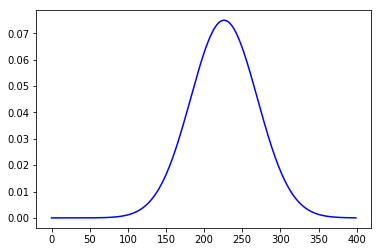

In [57]:
plt.plot(posteriors[-1].eval(np.arange(-1.0, 3.0, 0.01).reshape(-1,1), log=False), '-b')

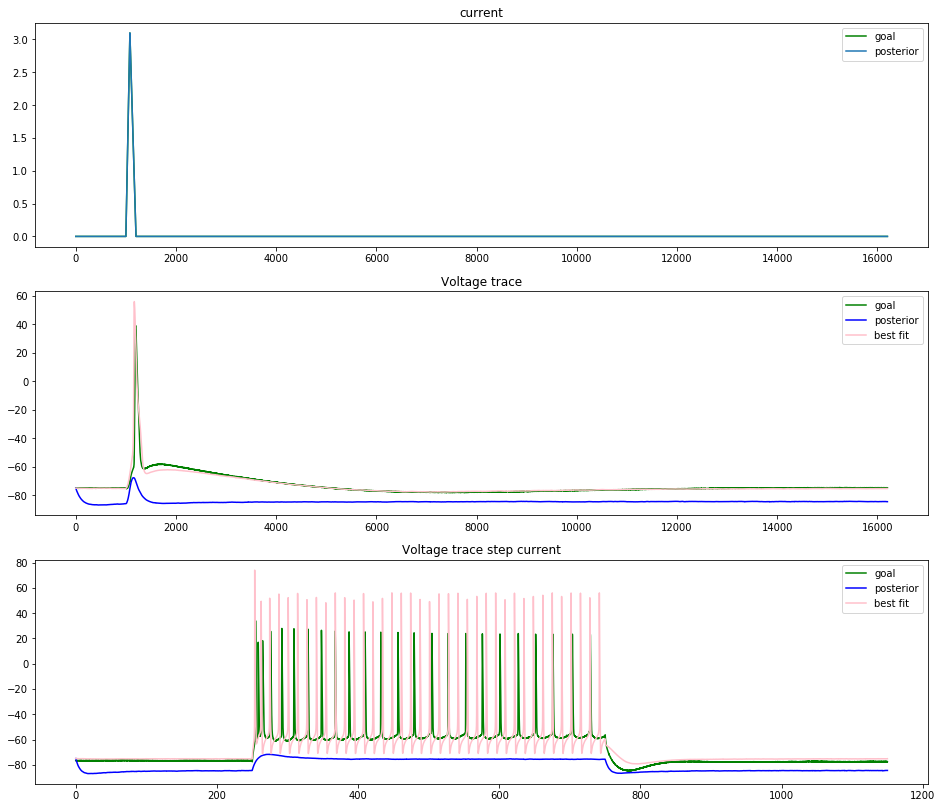

In [13]:
# Create Plots
simulation, axes = plt.subplots(3, 1, figsize=(16,14))
axes[0].plot(idx, x_o['I'], c='g', label='goal')
axes[0].plot(idx, x_post['I'], label='posterior')
axes[0].set_title('current')
axes[0].legend()

axes[1].plot(idx, x_o['data'], c='g', label='goal')
axes[1].plot(idx, x_post['data'], c='b', label='posterior')
axes[1].plot(idx, U, c='pink', label='best fit')
axes[1].set_title('Voltage trace')
axes[1].legend()

axes[2].plot(t_step, v_step, c='g', label='goal')
axes[2].plot(t_step, x_post_step['data'], c='b', label='posterior')
axes[2].plot(t_step, U_step, c='pink', label='best fit')
axes[2].set_title('Voltage trace step current')
axes[2].legend()

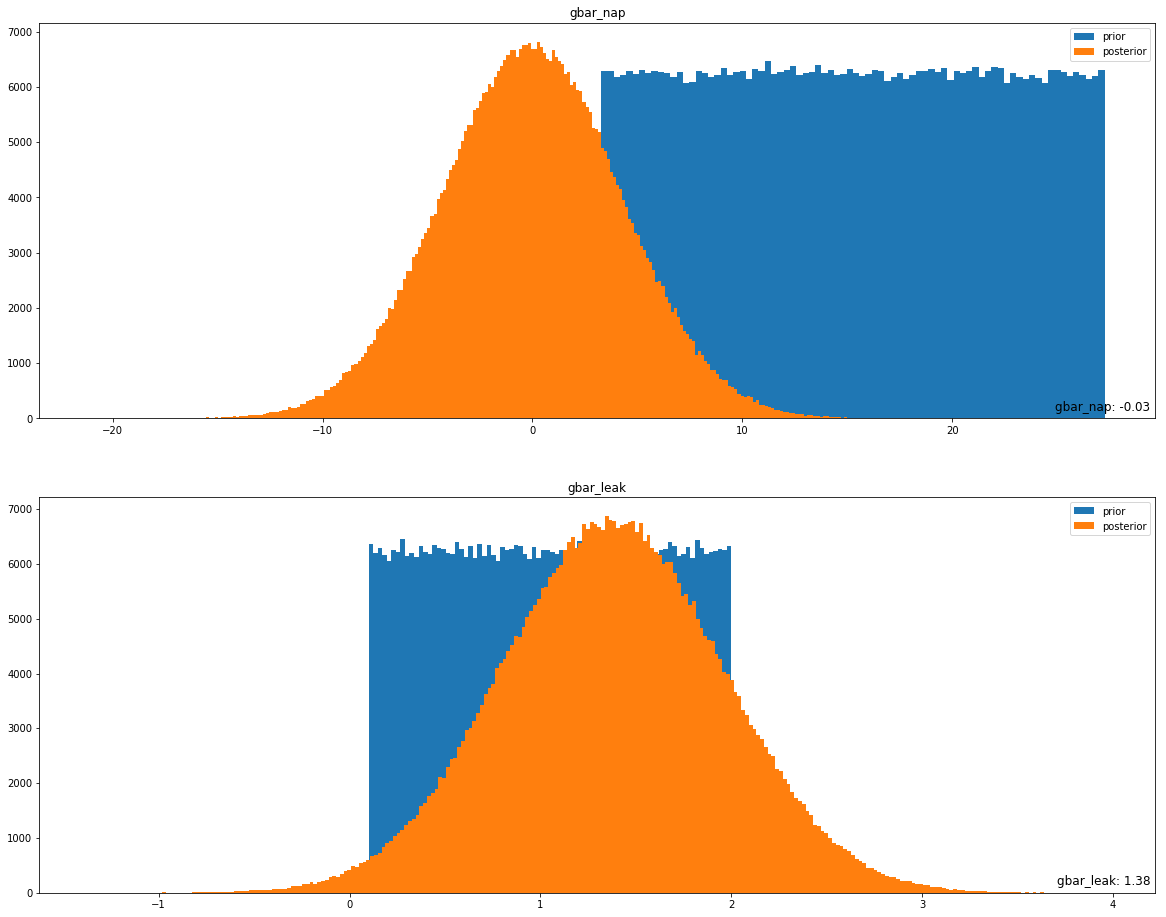

In [15]:
distr_comb, axes = plt.subplots(nrows=n_params, figsize=(20, 16))
for ii, l in enumerate(labels):

    axes[ii].hist(samples_prior[:, ii], bins='auto', label='prior')
    axes[ii].hist(samples_posterior[:, ii], bins='auto', label='posterior')

    axes[ii].set_title(l)
    axes[ii].annotate(l+': '+str(round(posteriors[-1].mean[ii], 2)),
                    xy=(1, 0), xycoords='axes fraction', fontsize=12,
                    xytext=(-5, 5), textcoords='offset points',
                    ha='right', va='bottom')

    axes[ii].legend();

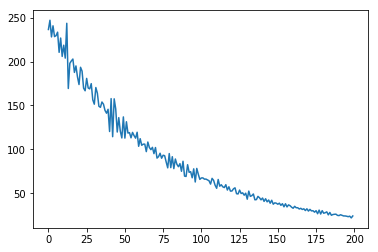

In [16]:
loss, ax = plt.subplots(1,1)
ax.plot(logs[0]['loss'])